https://github.com/qubvel/segmentation_models.pytorch

In [1]:
# Install required libs
#!pip install -U segmentation-models-pytorch albumentations --user 

In [2]:
#!pip uninstall -y segmentation-models-pytorch

### 

In [3]:
!nvidia-smi

Thu Mar  2 03:18:26 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 418.56       Driver Version: 418.56       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  GeForce GTX 108...  Off  | 00000000:5E:00.0 Off |                  N/A |
|  0%   44C    P5    14W / 280W |      0MiB / 11178MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
|   1  GeForce GTX 108...  Off  | 00000000:AF:00.0 Off |                  N/A |
|  0%   41C    P5    23W / 280W |      0MiB / 11178MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
        

In [4]:
from tqdm import tqdm
import glob, os
from urllib.request import urlretrieve
import shutil
import cv2
import random
# from tensorflow.keras.preprocessing.image import ImageDataGenerator
# import tensorflow as tf
# from tensorflow import keras

## Define functions to download an archived dataset and unpack it

In [5]:
# class TqdmUpTo(tqdm):
#     def update_to(self, b=1, bsize=1, tsize=None):
#         if tsize is not None:
#             self.total = tsize
#         self.update(b * bsize - self.n)


# def download_url(url, filepath):
#     directory = os.path.dirname(os.path.abspath(filepath))
#     os.makedirs(directory, exist_ok=False)
#     if os.path.exists(filepath):
#         print("Dataset already exists on the disk. Skipping download.")
#         return

#     with TqdmUpTo(unit="B", unit_scale=True, unit_divisor=1024, miniters=1, desc=os.path.basename(filepath)) as t:
#         urlretrieve(url, filename=filepath, reporthook=t.update_to, data=None)
#         t.total = t.n

# # 提取存檔檔案
# # os.path.dirname(path) 返回文件路徑
# # os.path.abspath(path) 返回絕對路徑
# def extract_archive(filepath):
#     extract_dir = os.path.dirname(os.path.abspath(filepath))
#     shutil.unpack_archive(filepath, extract_dir)

In [6]:
pwd

'/tf/notebook/0.research/kidney'

In [7]:
# 先建立 Data 資料夾
path = "./"
dataset_directory = os.path.join(path, "Data")

In [8]:
# # 在 Datasets 資料夾下建立 Brain_Tumour_Segmentation.zip 資料夾
# filepath = os.path.join(dataset_directory, "Brain_Tumour_Segmentation.zip")

# # download_url前面定義過，為了確認 Brain_Tumour_Segmentation.zip 資料夾是否存在，若存在則忽略
# # download_url(
# #     url="path", filepath=filepath,
# # )

# # 前面定義過，用來提取存檔檔案，並解壓縮
# extract_archive(filepath)

## Loading data

For this example we will use **CamVid** dataset. It is a set of:
 - **train** images + segmentation masks
 - **validation** images + segmentation masks
 - **test** images + segmentation masks
 
All images have 320 pixels height and 480 pixels width.
For more inforamtion about dataset visit http://mi.eng.cam.ac.uk/research/projects/VideoRec/CamVid/.

In [9]:
import os
# for 2 gpu
os.environ['CUDA_VISIBLE_DEVICES'] = '0,1'

import numpy as np
import cv2
import matplotlib.pyplot as plt

In [10]:
DATA_DIR = './0_Data/'

# DATA_DIR = './data/CamVid/'
# # load repo with data if it is not exists
# if not os.path.exists(DATA_DIR):
#     print('Loading data...')
#     os.system('git clone https://github.com/alexgkendall/SegNet-Tutorial ./data')
#     print('Done!')

In [11]:
# 叫出資料（原始影像＆Ｍask）的位置
x_train_dir = os.path.join(DATA_DIR, 'Train/img')
y_train_dir = os.path.join(DATA_DIR, 'Train/label')

x_valid_dir = os.path.join(DATA_DIR, 'Valid/img')
y_valid_dir = os.path.join(DATA_DIR, 'Valid/label')

x_test_dir = os.path.join(DATA_DIR, 'Test/img')
y_test_dir = os.path.join(DATA_DIR, 'Test/label')

In [12]:
print(x_train_dir)

./0_Data/Train/img


In [13]:
# print(len(x_train_dir))
# print(len(y_train_dir))

# print(len(x_valid_dir))
# print(len(y_valid_dir))

# print(len(x_test_dir))
# print(len(y_test_dir))

In [14]:
# helper function for data visualization
def visualize(**images):
    """PLot images in one row."""
    n = len(images)
    plt.figure(figsize=(16, 5))
    for i, (name, image) in enumerate(images.items()):
        plt.subplot(1, n, i + 1)
        plt.xticks([])
        plt.yticks([])
        plt.title(' '.join(name.split('_')).title())
        plt.imshow(image)
    plt.show()

### Dataloader

Writing helper class for data extraction, tranformation and preprocessing  
https://pytorch.org/docs/stable/data

In [15]:
from torch.utils.data import DataLoader
from torch.utils.data import Dataset as BaseDataset
from torchvision import transforms

In [16]:
class Dataset(BaseDataset):
    """CamVid Dataset. Read images, apply augmentation and preprocessing transformations.
    
    Args:
        images_dir (str): path to images folder
        masks_dir (str): path to segmentation masks folder
        class_values (list): values of classes to extract from segmentation mask
        augmentation (albumentations.Compose): data transfromation pipeline 
            (e.g. flip, scale, etc.)
        preprocessing (albumentations.Compose): data preprocessing 
            (e.g. noralization, shape manipulation, etc.)
    
    """
    
    # CLASSES = ['sky', 'building', 'pole', 'road', 'pavement', 
    #            'tree', 'signsymbol', 'fence', 'car', 
    #            'pedestrian', 'bicyclist', 'unlabelled']
    # CLASSES = ['tumor']
    CLASSES = ['bg','kidney']
    
    def __init__(
        self, 
        images_dir, 
        masks_dir, 
        classes=None, 
        augmentation=None, 
        preprocessing=None
        
    ):
        self.ids = os.listdir(images_dir)
        self.images_fps = [os.path.join(images_dir, image_id) for image_id in self.ids]
        self.masks_fps = [os.path.join(masks_dir, image_id) for image_id in self.ids]

        # convert str names to class values on masks
        self.class_values = [self.CLASSES.index(cls.lower()) for cls in classes]
        print('class_values:',self.class_values)
        
        self.augmentation = augmentation
        self.preprocessing = preprocessing
    
    def __getitem__(self, i):
        
        # read data
        image = cv2.imread(self.images_fps[i])
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        # read 灰階 mask
        mask = cv2.imread(self.masks_fps[i],0)
        # mask = cv2.cvtColor(mask, cv2.COLOR_BGR2GRAY)
        mask = mask//255
        
        # 將 1 channel 的 mask normalize 0~1
        # transform = transforms.Compose([
        #     transforms.ToTensor(),
        #     transforms.Normalize(mean = (0), std = (1))
        # ])
        # mask = transform(mask)
        # print('mask:',mask)
        # print('mask//255:',mask//255)
        # print(mask.shape)
        
        # extract certain classes from mask (e.g. tumor)
        masks = [(mask == v) for v in self.class_values]
        # print('masks(certain classes):',masks[0])
        mask = np.stack(masks, axis=-1).astype('float')
        
        # print('mask = masks (masks轉成數值並不定column維度):\n',mask[0])
        # print(mask.shape)
        
        # apply augmentations
        if self.augmentation:
            sample = self.augmentation(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']
        
        # apply preprocessing
        if self.preprocessing:
            sample = self.preprocessing(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']
        return image, mask
        
    def __len__(self):
        return len(self.ids)

class_values: [1]
(768, 1024, 1)
(768, 1024)
(768, 1024, 3)
(768, 1024, 3)


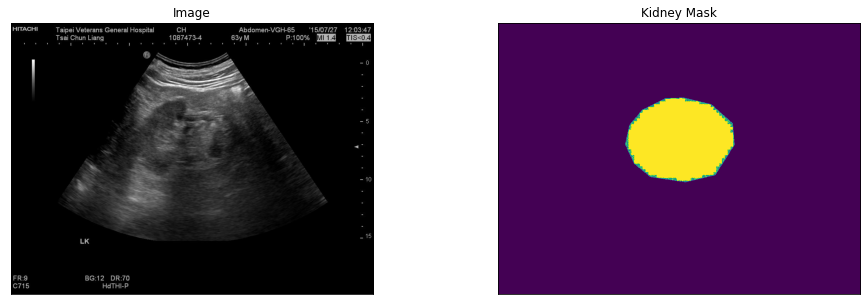

(768, 1024, 1)
(768, 1024)


In [17]:
# Lets look at data we have

dataset = Dataset(x_train_dir, y_train_dir, classes=['kidney'])

image, mask = dataset[4] # get some sample
print(mask.shape)
print(mask.squeeze().shape)
print(image.shape)
print(image.squeeze().shape)
visualize(
    image=image.squeeze(),#(H,W)
    kidney_mask=mask.squeeze(),#為了符合image shape,(B,H,W,c)-->(H,W)
)


# print('image:\n',image)
# print('mask[0]:\n',mask[0])
print(mask.shape)
print(mask.squeeze().shape)

In [18]:
# print(image.shape)
# print(mask.shape)
# print(mask[0])
# print(len(dataset))
# print(dataset[4])


In [19]:
pwd

'/tf/notebook/0.research/kidney'

In [20]:
import glob
import os

# 將三個資料夾存入 dirlist
images = []

for image in glob.glob('./0_Data/Train/img/*.jpg'):
    # print(type(image))
    # image = sorted(image)
    images.append(image)
    # print(image)

In [21]:
from PIL import Image

w = []
h = []
for i in range(len(images)):
    im = Image.open(images[i])
    width, height = im.size
    w.append(width)
    h.append(height)
#     if width == width and height == height:
#         print(width, height)
    print(i)
    print(width, height)
# print(sorted(h))
# print(min(w),min(h))

0
800 564
1
1024 768
2
1024 768
3
960 720
4
1024 768
5
800 600
6
1050 788
7
800 564
8
1050 788
9
1024 768
10
1024 768
11
1050 788
12
800 564
13
1024 768
14
960 720
15
960 720
16
1024 768
17
1024 768
18
1024 768
19
640 476
20
1024 768
21
960 720
22
800 564
23
960 720
24
1024 768
25
800 564
26
800 600
27
1024 768
28
960 720
29
975 735
30
1024 768
31
960 720
32
1164 873
33
1024 768
34
640 476
35
1024 768
36
960 720
37
640 476
38
960 720
39
960 720
40
1024 768
41
800 564
42
1024 768
43
1050 788
44
1024 768
45
640 476
46
960 720
47
640 476
48
1024 768
49
960 720
50
975 735
51
1024 768
52
960 720
53
1024 768
54
1050 788
55
1024 768
56
640 476
57
640 476
58
1024 768
59
1024 768
60
1024 768
61
640 476
62
640 476
63
800 600
64
800 564
65
1024 768
66
960 720
67
1024 768
68
1024 768
69
960 720
70
1024 768
71
975 735
72
1024 768
73
800 600
74
1024 768
75
800 564
76
640 476
77
1024 768
78
975 735
79
640 476
80
975 735
81
640 476
82
1024 768
83
1024 768
84
1164 873
85
800 564
86
800 564
87
960 720
8

### Augmentations

Data augmentation is a powerful technique to increase the amount of your data and prevent model overfitting.  
If you not familiar with such trick read some of these articles:
 - [The Effectiveness of Data Augmentation in Image Classification using Deep
Learning](http://cs231n.stanford.edu/reports/2017/pdfs/300.pdf)
 - [Data Augmentation | How to use Deep Learning when you have Limited Data](https://medium.com/nanonets/how-to-use-deep-learning-when-you-have-limited-data-part-2-data-augmentation-c26971dc8ced)
 - [Data Augmentation Experimentation](https://towardsdatascience.com/data-augmentation-experimentation-3e274504f04b)

Since our dataset is very small we will apply a large number of different augmentations:
 - horizontal flip
 - affine transforms
 - perspective transforms
 - brightness/contrast/colors manipulations
 - image bluring and sharpening
 - gaussian noise
 - random crops

All this transforms can be easily applied with [**Albumentations**](https://github.com/albu/albumentations/) - fast augmentation library.
For detailed explanation of image transformations you can look at [kaggle salt segmentation exmaple](https://github.com/albu/albumentations/blob/master/notebooks/example_kaggle_salt.ipynb) provided by [**Albumentations**](https://github.com/albu/albumentations/) authors.

In [22]:
# class AugDataset(BaseDataset):
    
#     CLASSES = ['bg','tumor']
    
#     def __init__(
#         self, 
#         images_dir, 
#         masks_dir, 
#         transform,
#         classes=None, 
#         augmentation=None, 
#         preprocessing=None
        
#     ):
#         self.ids = os.listdir(images_dir)
#         self.images_fps = [os.path.join(images_dir, image_id) for image_id in self.ids]
#         self.masks_fps = [os.path.join(masks_dir, image_id) for image_id in self.ids]
#         self.transform = transform
        
#         # convert str names to class values on masks
#         self.class_values = [self.CLASSES.index(cls.lower()) for cls in classes]
#         print('class_values:',self.class_values)
        
#         self.augmentation = augmentation
#         self.preprocessing = preprocessing
    
#     def __getitem__(self, i):
        
#         # read data
#         image = cv2.imread(self.images_fps[i])
#         image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
#         # read 灰階mask
#         mask = cv2.imread(self.masks_fps[i],0)
#         # mask = cv2.cvtColor(mask, cv2.COLOR_BGR2GRAY)
#         mask = mask//255
        
#         # extract certain classes from mask (e.g. tumor)
#         masks = [(mask == v) for v in self.class_values]
#         # print('masks(certain classes):',masks[0])
#         mask = np.stack(masks, axis=-1).astype('float32')
        
#         # print('mask = masks (masks轉成數值並不定column維度):\n',mask[0])
#         # print(mask.shape)
        
#         # apply augmentations
#         if self.augmentation:
#             sample = self.augmentation(image=image, mask=mask)
#             image, mask = sample['image'], sample['mask']
        
#         # apply preprocessing
#         if self.preprocessing:
#             sample = self.preprocessing(image=image, mask=mask)
#             image, mask = sample['image'], sample['mask']
            
#         if self.transform is not None:
#             image = self.transform(image)
#             mask = self.transform(mask)

#         return image, mask
        
#     def __len__(self):
#         return len(self.ids)

In [23]:
import albumentations as albu

In [24]:
def get_training_augmentation():

    train_transform = [
        albu.HorizontalFlip(p=0.5),
        # 2023.2.19 不要 scale，scale_limit 由 0.5 改為 0
        albu.ShiftScaleRotate(scale_limit=0, rotate_limit=0, shift_limit=0.1, p=1, border_mode=0),

        albu.PadIfNeeded(min_height=704, min_width=704, always_apply=True, border_mode=0),# padding 的概念
        albu.RandomCrop(height=704, width=704, always_apply=True),

        albu.IAAAdditiveGaussianNoise(p=0.2),
        albu.IAAPerspective(p=0.5),# 將圖片投影到新的平面

        albu.OneOf(
            [
                albu.CLAHE(p=1),
                albu.RandomBrightness(p=1),
                albu.RandomGamma(p=1),
            ],
            p=0.9,
        ),

        albu.OneOf(
            [
                albu.IAASharpen(p=1),
                albu.Blur(blur_limit=3, p=1),
                albu.MotionBlur(blur_limit=3, p=1),
            ],
            p=0.9,
        ),

        albu.OneOf(
            [
                albu.RandomContrast(p=1),
                albu.HueSaturationValue(p=1),
            ],
            p=0.9,
        ),
    ]
    return albu.Compose(train_transform)

"""Add paddings to make image shape divisible by 32"""
def get_validation_augmentation():
    test_transform = [
#         albu.PadIfNeeded(704, 704)
        # 2023.2.18 added
        albu.PadIfNeeded(min_height=704, min_width=704, always_apply=True, border_mode=0),
        albu.RandomCrop(height=704, width=704, always_apply=True),
    ]
    return albu.Compose(test_transform)


def to_tensor(x, **kwargs):
    return x.transpose(2, 0, 1).astype('float32')


def get_preprocessing(preprocessing_fn):
    """Construct preprocessing transform
    
    Args:
        preprocessing_fn (callbale): data normalization function 
            (can be specific for each pretrained neural network)
    Return:
        transform: albumentations.Compose
    
    """
    
    _transform = [
        albu.Lambda(image=preprocessing_fn),
        albu.Lambda(image=to_tensor, mask=to_tensor),
    ]
    return albu.Compose(_transform)

class_values: [1]
0


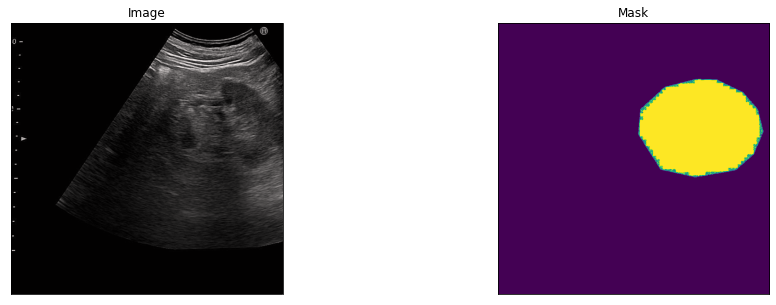

1


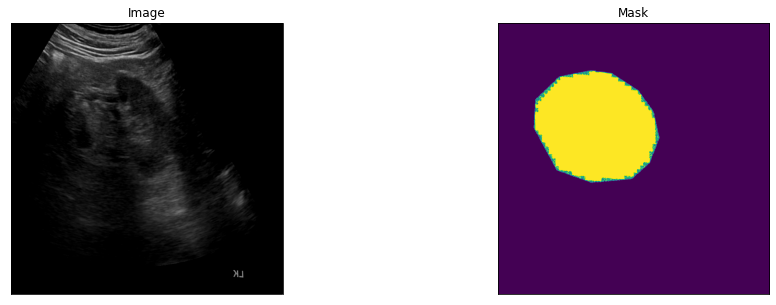

2


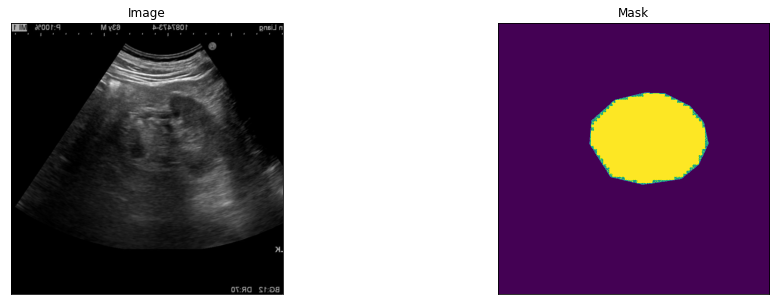

(704, 704, 1)
(704, 704)


In [25]:
#### Visualize resulted augmented images and masks

augmented_dataset = Dataset(
    x_train_dir, 
    y_train_dir, 
    augmentation=get_training_augmentation(), 
    classes=['kidney'],
)

# same image with different random transforms
for i in range(3):
    image, mask = augmented_dataset[4]
    print(i)
    visualize(image=image, mask=mask.squeeze())#-1
print(mask.shape)
print(mask.squeeze().shape)

## Create model and train

In [26]:
!pwd
# %cd ./Segmentation/

/tf/notebook/0.research/kidney


In [27]:
# !pip install timm
# !pip install pretrainedmodels
# !pip install efficientnet_pytorch

In [28]:
# !pip install -U git+https://github.com/qubvel/segmentation_models.pytorch

In [29]:
%cd ./2_segmentation_models/

/tf/notebook/0.research/kidney/2_segmentation_models


In [30]:
import torch
import numpy as np
import segmentation_models_pytorch as smp

In [31]:
%cd ../

/tf/notebook/0.research/kidney


### 設定encoder, weight, class, activation, device

In [32]:
ENCODER = 'resnet101'
ENCODER_WEIGHTS = 'imagenet'
CLASSES = ['kidney']
ACTIVATION = 'sigmoid' # could be None for logits or 'softmax2d' for multiclass segmentation
# DEVICE = 'cuda'
# 2023.3.1 added for hausdorff loss
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu") 

# create segmentation model with pretrained encoder
# DeepLabV3
# Unet
model = smp.DeepLabV3(
    encoder_name=ENCODER, 
    encoder_weights=ENCODER_WEIGHTS, 
    classes=len(CLASSES), 
    activation=ACTIVATION,
    # encoder_depth=3,
    # decoder_channels = (256, 128, 64)
)

# 2023.02.18 added for 2 gpu
model = torch.nn.DataParallel(model, device_ids=[0,1])

# 2023.3.1 added for torch.device("cuda" if torch.cuda.is_available() else "cpu") 
model = model.to(DEVICE)

# model = smp.Unet('resnet34', encoder_depth=4)
preprocessing_fn = smp.encoders.get_preprocessing_fn(ENCODER, ENCODER_WEIGHTS)

In [33]:
# # Check if double GPU is available
# if torch.cuda.device_count() > 1:
#     print("Using", torch.cuda.device_count(), "GPUs.")
#     model = torch.nn.DataParallel(model)
# else:
#     print("Using single GPU or CPU.")
#     model = model
# # Move the model to the selected device
# device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# model.to(device)

In [34]:
# # Use all available GPUs
# if torch.cuda.device_count() > 1:
#     print("Using", torch.cuda.device_count(), "GPUs.")
#     model = torch.nn.DataParallel(model)
# else:
#     print("Using single GPU.")
#     model = model

# # Use both GPUs if available
# if torch.cuda.device_count() >= 2:
#     device = torch.device("cuda:0,1")
#     print("Using", torch.cuda.device_count(), "GPUs.")
# else:
#     device = torch.device("cpu")
#     print("Using CPU.")

In [35]:
# if torch.cuda.device_count() > 1:
#     print("Let's use", torch.cuda.device_count(), "GPUs!")
#     # dim = 0 [30, xxx] -> [10, ...], [10, ...], [10, ...] on 3 GPUs
#     model = torch.nn.DataParallel(model)

# model = model.to(DEVICE)

### transform (resize, normalize) data

In [36]:
# transforms = transforms.Compose([
#     transforms.Resize((224, 224)),
#     transforms.ToTensor(),
#     transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
# ])

In [37]:
train_dataset = Dataset(
    x_train_dir, 
    y_train_dir, 
    augmentation=get_training_augmentation(), 
    preprocessing=get_preprocessing(preprocessing_fn),
    classes=CLASSES,
)

valid_dataset = Dataset(
    x_valid_dir, 
    y_valid_dir, 
    augmentation=get_validation_augmentation(), 
    preprocessing=get_preprocessing(preprocessing_fn),
    classes=CLASSES,
)

# train_loader = DataLoader(train_dataset, batch_size=5, shuffle=True, num_workers=0)
# valid_loader = DataLoader(valid_dataset, batch_size=5, shuffle=False, num_workers=0)

class_values: [1]
class_values: [1]


In [38]:
!pwd

/tf/notebook/0.research/kidney


### 設定loss, optimizer

In [39]:
from segmentation_models_pytorch import utils

In [40]:
pwd

'/tf/notebook/0.research/kidney'

In [41]:
# Dice/F1 score - https://en.wikipedia.org/wiki/S%C3%B8rensen%E2%80%93Dice_coefficient
# IoU/Jaccard score - https://en.wikipedia.org/wiki/Jaccard_index

# JaccardLoss
# DiceLoss
train_loss = valid_loss = smp.utils.losses.DiceLoss()

# TverskyLoss 2023.2.27 added
# train_loss = valid_loss = smp.losses.TverskyLoss('binary')
# train_loss.__name__ = 'tversky_loss'
# valid_loss.__name__ = 'tversky_loss'

# Hausdorff loss 2023.3.1 added
# %cd ./2_segmentation_models/segmentation_models_pytorch/losses/
# from hausdorff_loss import HausdorffDTLoss, HausdorffERLoss
# %cd ../../../
# train_loss = valid_loss = HausdorffDTLoss()
# train_loss.__name__ = 'hausdorffdt_loss'
# valid_loss.__name__ = 'hausdorffdt_loss'

metrics = [
    smp.utils.metrics.IoU(threshold=0.5),
]

optimizer = torch.optim.Adam([ 
    dict(params=model.parameters(), lr=0.0001),
])

### epoch runners 

In [42]:
# create epoch runners 
# it is a simple loop of iterating over dataloader`s samples
# train_epoch = smp.utils.train.TrainEpoch(
#     model, 
#     loss=loss, 
#     metrics=metrics, 
#     optimizer=optimizer,
#     device=DEVICE,
#     verbose=True,
# )

# valid_epoch = smp.utils.train.ValidEpoch(
#     model, 
#     loss=loss, 
#     metrics=metrics, 
#     device=DEVICE,
#     verbose=True,
# )

# 2023.2.24 added for k-fold
train_k_fold_epoch = smp.utils.train.Train_kFold_Epoch(
    model, 
    train_loss=train_loss,
    valid_loss=valid_loss,
    metrics=metrics,
    optimizer=optimizer,
    device=DEVICE,
    verbose=True,
)

### train!!

In [43]:
from pathlib import Path

# myfile = Path('./weight/best_model_deeplabv3_0513.pth')
# myfile.touch(exist_ok=False)
# f = open(myfile)

In [44]:
# Early stopping
patience = 5 #  Loss 連續下降 5 次就要停止訓練
trigger_times = 0

In [45]:
# 2023.2.24 added
# k-fold method
from torch.utils.data import ConcatDataset

dataset = ConcatDataset([train_dataset, valid_dataset])
print(len(dataset))

255


In [46]:
# # from tqdm.notebook import tqdm

# max_score = 0
# train_logs_list, valid_logs_list = [], []

# # for i in tqdm(range(0, 40)):
# for i in range(0, 170):
#     print('\nEpoch : {}'.format(i+1))
#     train_logs = train_epoch.run(train_loader)
#     valid_logs = valid_epoch.run(valid_loader)
#     train_logs_list.append(train_logs)
#     valid_logs_list.append(valid_logs)
    
#     # 2023.2.19 added early stopping
#     # 當前 loss > 前一次 loss 或 當前 loss < 前一次 loss (差距 5e-3)
# #     if i > 0 :
# #         if valid_logs['dice_loss'] > valid_logs_list[i-1]['dice_loss'] or (valid_logs_list[i-1]['dice_loss'] - valid_logs['dice_loss']) < 5e-3 :
# #             trigger_times += 1
# #             print('trigger times:', trigger_times)
# #             if trigger_times >= patience:
# #                 print('Early stopping!')
# #                 break
# #         else:
# #             print('trigger times: 0')
# #             trigger_times = 0
    
#     # do something (save model, change lr, etc.)
#     if max_score < valid_logs['iou_score']:
#         max_score = valid_logs['iou_score']
#         torch.save(model, './1_weight/best_model_deeplabv3_dice_03.pth')
#         print('Model saved!')
        
# #     if i == 25:
# #         optimizer.param_groups[0]['lr'] = 1e-5
# #         print('Decrease decoder learning rate to 1e-5!')

In [47]:
# 2023.2.25 added  for k-fold
# from tqdm.notebook import tqdm
path = f'./1_weight/best_model_deeplabv3_DiceLoss_0302_'
train_logs_list, valid_logs_list = train_k_fold_epoch.run(dataset, k=3, train_bz=10, valid_bz=5, epochs=170, model=model, path=path)

-------Start training-------
len of dataset : 255
len of train_idx, /ntrain_idx : (170, 85)

Fold : 1

Epoch : 1
train:   0%|          | 0/17 [00:06<?, ?it/s]


RuntimeError: Caught RuntimeError in replica 0 on device 0.
Original Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/torch/nn/parallel/parallel_apply.py", line 61, in _worker
    output = module(*input, **kwargs)
  File "/usr/local/lib/python3.6/dist-packages/torch/nn/modules/module.py", line 889, in _call_impl
    result = self.forward(*input, **kwargs)
  File "/tf/notebook/0.research/kidney/2_segmentation_models/segmentation_models_pytorch/base/model.py", line 29, in forward
    features = self.encoder(x)
  File "/usr/local/lib/python3.6/dist-packages/torch/nn/modules/module.py", line 889, in _call_impl
    result = self.forward(*input, **kwargs)
  File "/tf/notebook/0.research/kidney/2_segmentation_models/segmentation_models_pytorch/encoders/resnet.py", line 62, in forward
    x = stages[i](x)
  File "/usr/local/lib/python3.6/dist-packages/torch/nn/modules/module.py", line 889, in _call_impl
    result = self.forward(*input, **kwargs)
  File "/usr/local/lib/python3.6/dist-packages/torch/nn/modules/container.py", line 119, in forward
    input = module(input)
  File "/usr/local/lib/python3.6/dist-packages/torch/nn/modules/module.py", line 889, in _call_impl
    result = self.forward(*input, **kwargs)
  File "/usr/local/lib/python3.6/dist-packages/torchvision/models/resnet.py", line 124, in forward
    out = self.conv1(x)
  File "/usr/local/lib/python3.6/dist-packages/torch/nn/modules/module.py", line 889, in _call_impl
    result = self.forward(*input, **kwargs)
  File "/usr/local/lib/python3.6/dist-packages/torch/nn/modules/conv.py", line 399, in forward
    return self._conv_forward(input, self.weight, self.bias)
  File "/usr/local/lib/python3.6/dist-packages/torch/nn/modules/conv.py", line 396, in _conv_forward
    self.padding, self.dilation, self.groups)
RuntimeError: CUDA out of memory. Tried to allocate 38.00 MiB (GPU 0; 10.92 GiB total capacity; 10.09 GiB already allocated; 31.50 MiB free; 10.13 GiB reserved in total by PyTorch)


In [ ]:
# valid_logs['dice_loss']#0.18774815400441489
# # # max_score
# # # valid_logs_list
# valid_logs_list
# train_logs_list

### learning curve

In [ ]:
import pandas as pd
# assign data of lists
train_logs_df = pd.DataFrame(train_logs_list)
valid_logs_df = pd.DataFrame(valid_logs_list)
# train_logs_df／

In [ ]:
# # plot dice loss

# #前面先用list將要畫的變數存起來

# #迭代了10次(epoch)，所以x的取值範圍是(0，10)，然後再把每次相對應的準確率和loss值附在x上


# # x1 = range(0, epochs)
# x1 = range(0, 170) #train_logs_list.index.tolist()
# # x2 = valid_logs_list.index.tolist()

# #jaccard_loss or dice_loss
# y1 = train_logs_df.dice_loss.tolist()#.tolist()可以將NumPy 陣列轉換為列表
# y2 = valid_logs_df.dice_loss.tolist()

# # subplot(numRows, numCols, plotNum) 
# # https://blog.csdn.net/gatieme/article/details/61416645
    
# # train_iou / train_iou
# plt.plot(x1, y1, linestyle='-', color='#9932cc')

# # valid_iou / valid_iou
# plt.plot(x1, y2, linestyle='-', color='#1e90ff') 


# plt.title('dice loss vs. epoches')
# plt.xlabel('Epochs')
# plt.ylabel('dice loss')
# plt.legend(('training', 'validation'),bbox_to_anchor=(1.05, 1.0), loc='upper left')
# # plt.ylim(0.975,1.005)

# plt.show()

In [ ]:
#畫圖

#前面先用list將要畫的變數存起來

#迭代了10次(epoch)，所以x的取值範圍是(0，10)，然後再把每次相對應的準確率和loss值附在x上


# x1 = range(0, epochs)
x1 = range(0, 170) #train_logs_list.index.tolist()
# x2 = valid_logs_list.index.tolist()

#jaccard_loss or dice_loss or tversky_loss
y1 = train_logs_df.hausdorffdt_loss.tolist()#.tolist()可以將NumPy 陣列轉換為列表
y2 = valid_logs_df.hausdorffdt_loss.tolist()


# train_Accuracy / valid_Accuracy
# plt.subplot(2, 1, 1) 
#subplot(numRows, numCols, plotNum) 
#https://blog.csdn.net/gatieme/article/details/61416645
#------ fold 1-------
plt.plot(x1, y1[:170],linestyle='-')#, color='#9932cc'
plt.plot(x1, y2[:170], linestyle='-') #, color='#1e90ff'
#------ fold 2-------
plt.plot(x1, y1[170:340],linestyle='-')
plt.plot(x1, y2[170:340], linestyle='-')
#------ fold 3-------
plt.plot(x1, y1[340:510],linestyle='-')
plt.plot(x1, y2[340:510],linestyle='-')
#------ fold 4-------
# plt.plot(x1, y1[510:680], linestyle='-') 
# plt.plot(x1, y2[510:680],linestyle='-')
# #------ fold 5-------
# plt.plot(x1, y1[680:], linestyle='-') 
# plt.plot(x1, y2[680:],linestyle='-')

plt.title('hausdorff loss vs. epoches')
plt.xlabel('Epochs')
plt.ylabel('dice loss')
plt.legend(('fold 1 training', 'fold 1 validation', 'fold 2 training', 'fold 2 validation', 'fold 3 training', 'fold 3 validation', 
           ),bbox_to_anchor=(1.05, 1.0), loc='upper left')
# plt.ylim(0.975,1.005)
# plt.ylim(0.975,1.005)

plt.show()
plt.savefig("accuracy_loss.jpg")

In [ ]:
# # plot iou score

# #前面先用list將要畫的變數存起來

# #迭代了10次(epoch)，所以x的取值範圍是(0，10)，然後再把每次相對應的準確率和loss值附在x上


# # x1 = range(0, epochs)
# x1 = range(0, 170) #train_logs_list.index.tolist()
# # x2 = valid_logs_list.index.tolist()

# y1 = train_logs_df.iou_score.tolist()#可以將NumPy 陣列轉換為列表
# y2 = valid_logs_df.iou_score.tolist()

# # subplot(numRows, numCols, plotNum) 
# # https://blog.csdn.net/gatieme/article/details/61416645
    
# # train_iou / train_iou
# plt.plot(x1, y1, linestyle='-', color='#9932cc')

# # valid_iou / valid_iou
# plt.plot(x1, y2, linestyle='-', color='#1e90ff') 


# plt.title('IOU vs. epoches')
# plt.xlabel('Epochs')
# plt.ylabel('IOU score')
# plt.legend(('training', 'validation'),bbox_to_anchor=(1.05, 1.0), loc='upper left')
# # plt.ylim(0.975,1.005)

# plt.show()

In [ ]:
x1 = range(0, 170) #train_logs_list.index.tolist()
# x2 = valid_logs_list.index.tolist()

#jaccard_loss or dice_loss
y1 = train_logs_df.iou_score.tolist()#.tolist()可以將NumPy 陣列轉換為列表
y2 = valid_logs_df.iou_score.tolist()


# train_Accuracy / valid_Accuracy
# plt.subplot(2, 1, 1) 
#subplot(numRows, numCols, plotNum) 
#https://blog.csdn.net/gatieme/article/details/61416645
#------ fold 1-------
plt.plot(x1, y1[:170],linestyle='-')#, color='#9932cc'
plt.plot(x1, y2[:170], linestyle='-') #, color='#1e90ff'
#------ fold 2-------
plt.plot(x1, y1[170:340],linestyle='-')
plt.plot(x1, y2[170:340], linestyle='-')
#------ fold 3-------
plt.plot(x1, y1[340:510],linestyle='-')
plt.plot(x1, y2[340:510],linestyle='-')
#------ fold 4-------
# plt.plot(x1, y1[510:680], linestyle='-') 
# plt.plot(x1, y2[510:680],linestyle='-')
# #------ fold 5-------
# plt.plot(x1, y1[680:], linestyle='-') 
# plt.plot(x1, y2[680:],linestyle='-')

plt.title('IoU score vs. epoches')
plt.xlabel('Epochs')
plt.ylabel('Score')
plt.legend(('fold 1 training', 'fold 1 validation', 'fold 2 training', 'fold 2 validation', 'fold 3 training', 'fold 3 validation', 
           ),bbox_to_anchor=(1.05, 1.0), loc='upper left')
# plt.ylim(0.975,1.005)
# plt.ylim(0.975,1.005)


plt.show()
plt.savefig("accuracy_loss.jpg")

## Test best saved model

In [ ]:
# load best saved checkpoint
best_model = torch.load('./1_weight/best_model_deeplabv3_DiceLoss_0302_fold1.pth')
# 2023.2.18 added (因為訓練是用 2 個 gpu，若不加以下程式碼，會出現 DataParallel' object has no attribute 'predict' 錯誤)
if isinstance(best_model,torch.nn.DataParallel):
    best_model = best_model.module
best_model.eval()

In [ ]:
# create test dataset
test_dataset = Dataset(
    x_test_dir, 
    y_test_dir, 
    augmentation=get_validation_augmentation(), 
    preprocessing=get_preprocessing(preprocessing_fn),
    classes=CLASSES,
)

test_dataloader = DataLoader(test_dataset, batch_size=3)

In [ ]:
# evaluate model on test set
test_epoch = smp.utils.train.ValidEpoch(
    model=best_model,
    valid_loss=valid_loss,
    train_loss=None,
    metrics=metrics,
    device=DEVICE,
)

logs = test_epoch.test_run(test_dataloader)

## Visualize predictions

In [ ]:
# test dataset without transformations for image visualization
test_dataset_vis = Dataset(
    x_test_dir, y_test_dir, 
    classes=CLASSES,
)

In [ ]:
for i in range(5):
    n = np.random.choice(len(test_dataset))
    
    image_vis = test_dataset_vis[n][0].astype('uint8')
    image, gt_mask = test_dataset[n]
    
    gt_mask = gt_mask.squeeze()
    
    x_tensor = torch.from_numpy(image).to(DEVICE).unsqueeze(0)
    pr_mask = best_model.predict(x_tensor)
    pr_mask = (pr_mask.squeeze().cpu().numpy().round())
        
#     visualize(
#         image=image_vis, 
#         ground_truth_mask=gt_mask, 
#         predicted_mask=pr_mask
#     )

### plot confusion matrix

In [ ]:
# print(gt_mask[0])
# print(gt_mask[0][0])
# print(gt_mask[0].shape)
# print(gt_mask[0].reshape(-1,1).shape)

In [ ]:

# # calculate confusion matrix
# # https://datascience.stackexchange.com/questions/28493/confusion-matrix-get-items-fp-fn-tp-tn-python

# def conf_matrix(y_gt, y_pred):
#     tp = 0
#     fp = 0
#     tn = 0
#     fn = 0
    
    # for i in range(len(y_pred)):
    #     for j in range(len(y_pred)):
    #         if y_pred[i][j] == y_gt[i][j] == 1:
    #             tp += 1
    #         if y_pred[i][j] == 1 and y_gt[i][j] != y_pred[i][j]:
    #             fp += 1
    #         if y_pred[i][j] == y_gt[i][j] == 0:
    #             tn += 1
    #         if y_pred[i][j] == 0 and y_gt[i][j] != y_pred[i][j]:
    #             fn += 1
    
    # for j in range(len(pr_mask)):
    #     for k in range(len(pr_mask)):
    #         if (pr_mask[j][k] == 1 and gt_mask[j][k] == 1):
    #             tp += 1
    #         if (pr_mask[j][k] == 1 and gt_mask[j][k] == 0):
    #             fp += 1
    #         if (pr_mask[j][k] == 0 and gt_mask[j][k] == 0):
    #             tn += 1
    #         if (pr_mask[j][k] == 0 and gt_mask[j][k] == 1): 
    #             fn += 1
            
    # return(tp, fp, tn, fn)

In [ ]:
import seaborn as sn
from sklearn.metrics import confusion_matrix
import pandas as pd

cf_matrix = confusion_matrix(gt_mask.reshape(-1,1), pr_mask.reshape(-1,1))
# tn, fp, fn, tp = confusion_matrix(list(gt_mask), list(pr_mask), labels=[0, 1]).ravel()
# tn, fp, fn, tp = conf_matrix(gt_mask.reshape(-1,1), pr_mask.reshape(-1,1))
print('confusion_matrix : ')
df_cm = pd.DataFrame(cf_matrix, 
                         index = [0, 1],
                         columns = [0, 1])
print(df_cm)

# https://medium.com/@dtuk81/confusion-matrix-visualization-fc31e3f30fea
x_axis_labels = ['Background', 'kidney']
y_axis_labels = ['Background', 'kidney']

plt.figure(figsize = (6,5))
sn.heatmap(cf_matrix/np.sum(cf_matrix), annot=True, cmap='RdPu', xticklabels=x_axis_labels, yticklabels=y_axis_labels)
plt.title('Confusion Matrix')
plt.xlabel("predictions")
plt.ylabel("ground truth")
plt.show()

In [ ]:
# print(np.sum(cf_matrix))# test_data數量
# print(cf_matrix)
len(gt_mask)

### metrics

In [ ]:
# 有兩種方法
# tp, fp, tn, fn = confusion_matrix(gt_mask.reshape(-1,1), pr_mask.reshape(-1,1)).ravel()
tn, fp, fn, tp = confusion_matrix(gt_mask.reshape(-1,1), pr_mask.reshape(-1,1)).ravel()
# or
# tp = cf_matrix[0][0]
# fp = cf_matrix[0][1]
# tn = cf_matrix[1][0]
# fn = cf_matrix[1][1]

print('TP: ' + str(tp) + ' pixels')
print('FP: ' + str(fp) + ' pixels')
print('TN: ' + str(tn) + ' pixels')
print('FN: ' + str(fn) + ' pixels')

In [ ]:
accuracy = (tp + tn) / (tp + tn + fp + fn)
print('accuracy = ', accuracy)

recall = tp / (tp + fn)
print('recall = ', recall)

precision = tp / (tp + fp)
print('precision = ', precision)

specificity = tn / (tn + fp)
print('specificity = ', specificity)

f1_score = (2 * tp) / ((2 * tp) + fp + fn)
print('f1 score = ', f1_score)

iou = tp / (tp + fp + fn)
print('IoU score = ', iou)

In [ ]:
# logs

In [ ]:
data = [accuracy, precision, recall, specificity, f1_score, iou]
datafeame = pd.DataFrame(data,
                         columns = ['Value'],
                         index = ['Accuracy', 'Recall', 'Precision', 'Specificity', 'F1 score', 'IoU score'])

datafeame

In [ ]:
# import sys
# import numpy
# numpy.set_printoptions(threshold=sys.maxsize)
# # print(gt_mask.reshape(-1,1))
# print(gt_mask)
# print(pr_mask)

https://towardsdatascience.com/a-simple-explanation-of-the-roc-curve-and-auc-64db32d75541
https://www.kaggle.com/code/kmader/use-roc-curves-to-evaluate-segmentation-methods

In [ ]:
import seaborn as sns
from sklearn.metrics import roc_curve, auc
sns.set_style('darkgrid')

fpr, tpr, thresholds = roc_curve(gt_mask.reshape(-1,1), pr_mask.reshape(-1,1))
def ROC_curve(fpr,tpr):
    # Seaborn's beautiful styling
#     sns.set_style('darkgrid', {'axes.facecolor': '0.9'})
#     plt.figure(figsize=(8, 5))
#     lw = 2
#     plt.plot(fpr, tpr, color='#eb669a', label='ROC')
    plt.plot(fpr, tpr, color='#eb669a', label='ROC curve (area = %0.3f)' % auc(fpr, tpr))
    plt.plot([0, 1], [0, 1], color='#4cc28e', linestyle='--')
#     plt.xlim([0.0, 1.0])
#     plt.ylim([0.0, 1.05])
#     plt.yticks([i/20.0 for i in range(21)])
#     plt.xticks([i/20.0 for i in range(21)])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic (ROC) Curve')
    plt.legend(loc='lower right')
    plt.show()
    
ROC_curve(fpr,tpr)
# print('AUROC: {}'.format(auc(fpr, tpr)))